In [1]:
!pip install opendatasets
!pip install bayesian-optimization

In [36]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [13]:
dataset_path = Path('wine-quality-dataset', 'WineQT.csv')

if not dataset_path.is_file():
    od.download('https://www.kaggle.com/datasets/yasserh/wine-quality-dataset')

df = pd.read_csv(dataset_path)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [14]:
# проверка на пропущенные значения и выбросы
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


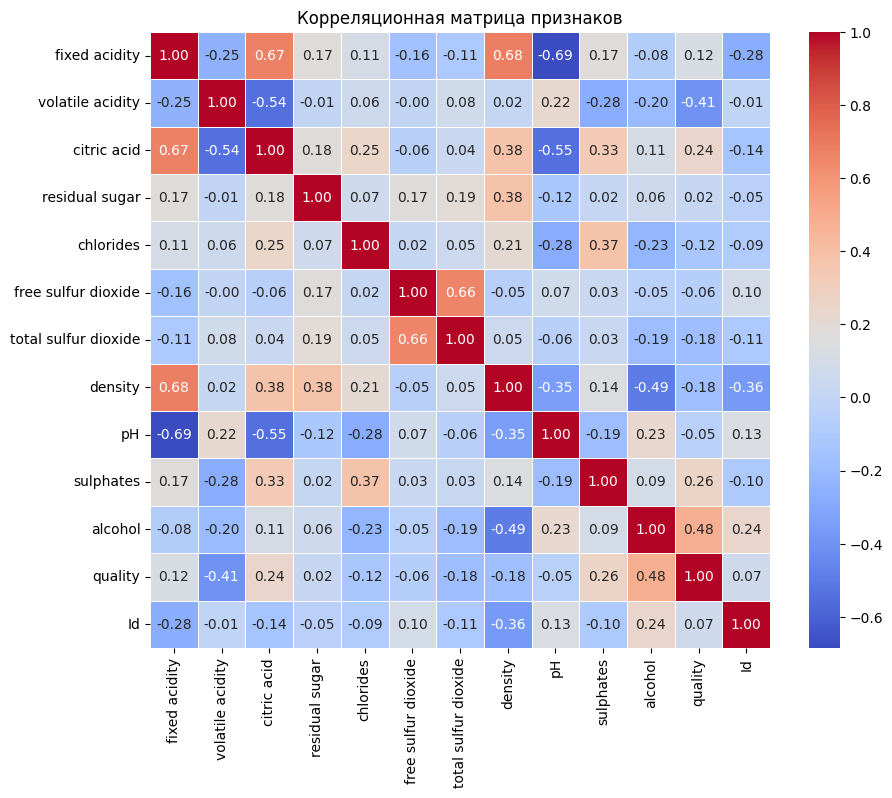

In [15]:
# Построение корреляционной матрицы
corr_matrix = df.corr()

# Визуализация с использованием heatmap
plt.figure(figsize=(10, 8))  # Размер изображения
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Корреляционная матрица признаков')
plt.show()

In [18]:
# Разделяем данные на признаки (X) и целевую переменную (y)
X = df.drop(columns=['quality', 'Id'])  # Удаляем 'quality' и 'Id'
y = df['quality']

# Разбиваем на обучающую и тестовую выборки (80% - обучение, 20% - тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Стандартизация признаков
scaler = StandardScaler()

# Применяем стандартизацию к обучающим данным
X_train_scaled = scaler.fit_transform(X_train)

# Применяем стандартизацию к тестовым данным (используем fit из обучающей выборки)
X_test_scaled = scaler.transform(X_test)

# Проверим, как выглядят стандартизированные данные
print("Обучающие данные после стандартизации:")
print(X_train_scaled[:5])  # Печать первых 5 строк обучающих данных

print("\nТестовые данные после стандартизации:")
print(X_test_scaled[:5])  # Печать первых 5 строк тестовых данных

Обучающие данные после стандартизации:
[[ 0.1426802  -1.40273053  1.5096933  -0.55102394  0.11651554  1.88559834
   1.79122276  0.11355786 -0.09314751  0.56821234  0.05661327]
 [ 0.96843134 -1.17920341  1.5096933  -0.39776844 -0.28423884 -1.24188154
  -1.18572018 -0.7017669  -1.07474038  0.4477703   0.89445566]
 [ 0.3786091  -1.23508519  0.4833938   0.06199805 -0.64280855 -0.55774532
  -0.21429669 -0.55542656  0.56124774  0.20688622  1.26683005]
 [-0.97798208  1.95017634 -1.1586854  -0.24451294 -0.43188519 -0.36227782
  -0.80968528 -0.16866994  1.41196156 -0.57598704 -0.50194833]
 [-0.38815983 -0.6203856  -0.08107092  1.0581588   0.36962357  1.20146211
   1.38385162  0.6048433  -1.07474038 -0.51576602 -1.24669712]]

Тестовые данные после стандартизации:
[[-0.86001763  0.44136825 -1.1586854  -0.78090719 -0.62171622 -1.04641405
  -1.1230477  -0.74880486  0.69212679 -0.33510296 -0.87432272]
 [-0.8010354   1.72664922 -0.28633082  1.2114143  -0.26314651  0.02865716
   0.60044559  0.90797686

In [31]:
# Создание модели
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(250, activation='relu')) # скрытый слой
model.add(Dense(100, activation='relu')) # скрытый слой
model.add(Dense(50, activation='relu')) # скрытый слой
model.add(Dense(1, activation='linear')) # выходной слой с линейной функцией активации

# Компиляция модели
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae', 'mse'])

# Обучение модели
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test_scaled, y_test),
                    verbose=1)  # Показывать процесс обучения

# Оценка модели на тестовой выборке
loss, mae, mse = model.evaluate(X_test_scaled, y_test)
print(f'Test Loss (MSE): {loss}')
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')

# Предсказания на тестовых данных
y_pred = model.predict(X_test_scaled)

# Пример: Можем вывести первые 5 предсказаний и реальные значения
print(f'Predictions: {y_pred[:5].flatten()}')
print(f'Actual values: {y_test[:5].values}')

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 18.6629 - mae: 3.9289 - mse: 18.6629 - val_loss: 3.6422 - val_mae: 1.4107 - val_mse: 3.6422
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5086 - mae: 1.2477 - mse: 2.5086 - val_loss: 2.3716 - val_mae: 1.2093 - val_mse: 2.3716
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7255 - mae: 1.0344 - mse: 1.7255 - val_loss: 1.9182 - val_mae: 1.0984 - val_mse: 1.9182
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3888 - mae: 0.9426 - mse: 1.3888 - val_loss: 1.5502 - val_mae: 0.9842 - val_mse: 1.5502
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2823 - mae: 0.8995 - mse: 1.2823 - val_loss: 1.3392 - val_mae: 0.9050 - val_mse: 1.3392
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1197 - mae: 0.8397 - mse: 1.1197 - val_loss: 1.0347 - val_mae: 0.8040 - val_mse: 1.0347
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8826 - mae: 0.7404 - mse: 0.8826 - val_loss: 0.906

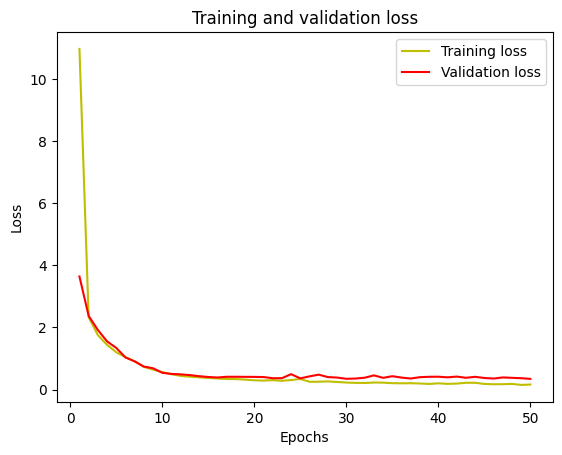

In [32]:
# Получаем значения потерь для обучения и валидации
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Строим график
plt.plot(epochs, loss, 'y', label='Training loss')  # Потери на обучающей выборке (горчичный)
plt.plot(epochs, val_loss, 'r', label='Validation loss')  # Потери на валидационной выборке (красный)

# Добавляем заголовок и подписи
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Добавляем легенду
plt.legend()

# Показываем график
plt.show()

In [34]:
# Предсказания модели на тестовых данных
y_pred = model.predict(X_test_scaled)

# Средняя абсолютная ошибка (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Средняя квадратичная ошибка (MSE)
mse = mean_squared_error(y_test, y_pred)

# Корень из средней квадратичной ошибки (RMSE)
rmse = np.sqrt(mse)

# Коэффициент детерминации (R²)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Mean Absolute Error (MAE): 0.4334661887722765
Mean Squared Error (MSE): 0.3425209355648706
Root Mean Squared Error (RMSE): 0.5852528817228246
R² Score: 0.38447874784469604
